In [156]:
from pathlib import Path
import json
import pandas as pd
import numpy as np

# Pandas data processing

## Gather Data + Cleanup
 - Throwaway keys irrelevant for the figures and do renaming

In [163]:
def cleanup(df, rename, include):
    # rename
    for (key_name, key), v in rename.items():
        df.loc[df[key_name] == key, key_name] = v

    # only keep things in include
    return df[df['key'].isin(include)].reset_index(drop=True)

# polybench data
standard_hls = pd.read_csv("../results/standard/hls/data.csv")
standard_futil = pd.read_csv("../results/standard/futil/data.csv")
standard_futil_lat = pd.read_csv("../results/standard/futil-latency/data.csv")
unrolled_hls = pd.read_csv("../results/unrolled/hls/data.csv")
unrolled_futil = pd.read_csv("../results/unrolled/futil/data.csv")
unrolled_futil_lat = pd.read_csv("../results/unrolled/futil-latency/data.csv")
polybench_raw = standard_hls.append(standard_futil).append(standard_futil_lat).append(unrolled_hls).append(unrolled_futil).append(unrolled_futil_lat).reset_index(drop=True)
polybench = cleanup(polybench_raw, {
    ('key', 'avg_latency'): 'latency',
}, ['dsp', 'lut', 'latency'])

# systolic data
hls = pd.read_csv("../results/systolic/hls/data.csv")
futil = pd.read_csv("../results/systolic/futil/data.csv")
futil_lat = pd.read_csv("../results/systolic/futil-latency/data.csv")
systolic_raw = hls.append(futil).append(futil_lat).reset_index(drop=True)
systolic = cleanup(systolic_raw, {
    ('key', 'avg_latency'): 'latency',
    ('benchmark', 'gemm2'): '2 x 2',
    ('benchmark', 'gemm4'): '4 x 4',
    ('benchmark', 'gemm6'): '6 x 6',
    ('benchmark', 'gemm8'): '8 x 8',
}, ['dsp', 'lut', 'latency'])

# latency insensitive data
with_static_timing = pd.read_csv('../results/latency-sensitive/with-static-timing/data.csv')
no_static_timing = pd.read_csv('../results/latency-sensitive/no-static-timing/data.csv')
latency_sensitive_raw = with_static_timing.append(no_static_timing).reset_index(drop=True)
latency_sensitive = cleanup(latency_sensitive_raw, {}, ['latency'])

## Calculate norms 

In [164]:
def match(df, benchmark, typ):
    return df[(df['benchmark'] == benchmark) & (df['type'] == typ)]

def norm(df, top_key, bot_key, name):
    df = df.copy()
    for bench in df['benchmark'].unique():
        norm = match(df, bench, top_key).copy()
        norm['value'] = match(df, bench, top_key)['value'].values / match(df, bench, bot_key)['value'].values
        norm['type'] = name
        df = df.append(norm)
    return df
        
polybench = norm(polybench, 'futil', 'hls', 'norm')
polybench = norm(polybench, 'futil-unrolled', 'hls-unrolled', 'norm-unrolled')
latency_sensitive = norm(latency_sensitive, 'with-static-timing', 'no-static-timing', 'norm')

## Dataframe formatting
 - Transition from long-form to short-form data by using `pivot`.
 - Reorder table so that unrolled benchmarks are grouped at the beginning

In [165]:
def pivot_and_order(df, order):
    df = df.pivot(index=['benchmark', 'type'], columns='key', values='value').reset_index()
    df['benchmark'] = pd.Categorical(df['benchmark'], order)
    return df

polybench_order = [
    '2mm', '3mm', 'atax','doitgen','gemm',
    'gemver','gesummv','gramschmidt','mvt',
    'syr2k', 'syrk','bicg','cholesky','durbin',
    'lu','ludcmp','symm','trisolv', 'trmm'
]

polybench = pivot_and_order(polybench, polybench_order)

systolic = pivot_and_order(systolic, [
    '2 x 2', 
    '4 x 4',
    '6 x 6',
    '8 x 8'
])

latency_sensitive = pivot_and_order(latency_sensitive, polybench_order)

## Helpers

In [166]:
def apply_legend(df, name, legend):
    df[name] = df[name].copy().apply(lambda x: legend[x])
    return df

# Graph Generation

## 5a. Systolic Array Normalized cycle counts

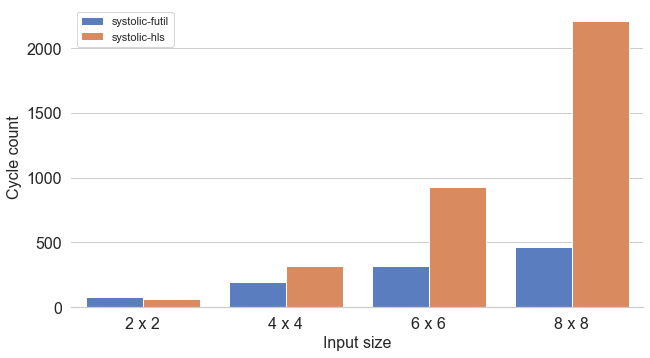

In [167]:
g = sns.catplot(
    x="benchmark", 
    y="latency", 
    hue="type", 
    data=systolic,
    kind="bar", 
    palette="muted",
    legend=False,
)
g.despine(left=True)
g.set_ylabels("Cycle count", fontsize=16)
g.set_xlabels("Input size", fontsize=16)
g.set_yticklabels(fontsize=16)
g.set_xticklabels(fontsize=16)
g.axes[0,0].legend(loc='upper left',).set_title('')
g.fig.set_size_inches(10,5)

## 5b. Systolic Array Normalized LUT usage

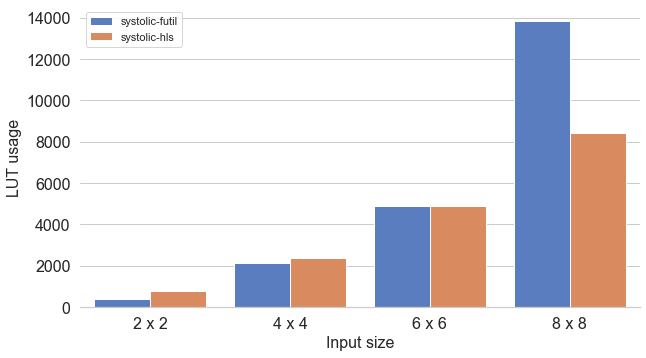

In [168]:
g = sns.catplot(
    x="benchmark", 
    y="lut", 
    hue="type", 
    data=systolic,
    kind="bar", 
    palette="muted",
    legend=False,
)
g.despine(left=True)
g.set_ylabels("LUT usage", fontsize=16)
g.set_xlabels("Input size", fontsize=16)
g.set_yticklabels(fontsize=16)
g.set_xticklabels(fontsize=16)
g.axes[0,0].legend(loc='upper left',).set_title('')
g.fig.set_size_inches(10,5)

## 6a. Cycle counts normalized to Vivado HLS

<ipython-input-166-0f1354189136>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = df[name].copy().apply(lambda x: legend[x])


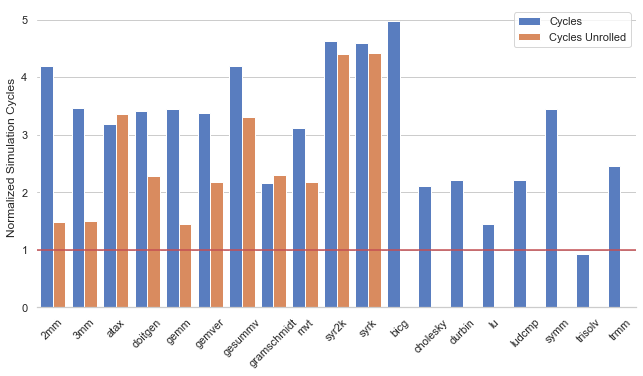

In [169]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

legend = {
    'norm': 'Cycles',
    'norm-unrolled': 'Cycles Unrolled'
}

df = polybench[polybench['type'].isin(['norm', 'norm-unrolled'])]
g = sns.catplot(
    x="benchmark",
    y="latency",
    hue="type",
    data=apply_legend(df, 'type', legend),
    kind="bar",
    palette="muted",
    legend=False,
)
g.despine(left=True)
g.set_ylabels("Normalized Simulation Cycles")
g.set_xlabels("")
g.set_xticklabels(rotation=45)
g.axes[0,0].legend(loc='upper right').set_title('')
g.axes[0,0].axhline(1, color="r")
g.fig.set_size_inches(10,5)

## 6b. LUT usage normalized to Vivado HLS

<ipython-input-166-0f1354189136>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = df[name].copy().apply(lambda x: legend[x])


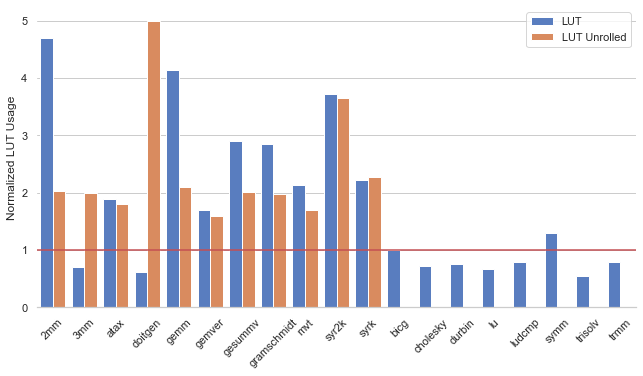

In [170]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

legend = {
    'norm': 'LUT',
    'norm-unrolled': 'LUT Unrolled'
}

df = polybench[polybench['type'].isin(['norm', 'norm-unrolled'])]
g = sns.catplot(
    x="benchmark",
    y="lut",
    hue="type",
    data=apply_legend(df, 'type', legend),
    kind="bar",
    palette="muted",
    legend=False,
)
g.despine(left=True)
g.set_ylabels("Normalized LUT Usage")
g.set_xlabels("")
g.set_xticklabels(rotation=45)
g.axes[0,0].legend(loc='upper right').set_title('')
g.axes[0,0].axhline(1, color="r")
g.fig.set_size_inches(10,5)

## 6c. Cycle counts normalized to latency-insensitive design 

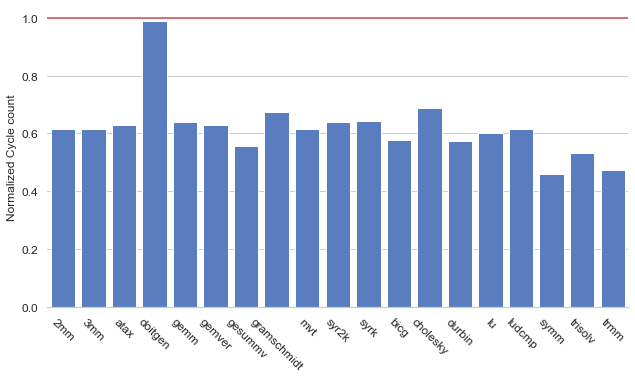

In [171]:
df = latency_sensitive
g = sns.catplot(
    x="benchmark", 
    y="latency",
    hue="type",
    data=df[df['type'] == 'norm'],
    kind="bar", 
    palette="muted",
    legend=False,
)
g.despine(left=True)
g.set_ylabels("Normalized Cycle count", fontsize=12)
g.set_xlabels("")
g.set_xticklabels(rotation=-45, fontsize=12)
g.fig.set_size_inches(10,5)

g.axes[0,0].axhline(1, color='r')
for l in g.axes[0,0].get_yticklabels(): l.set_fontsize(12) # I hate this, but otherwise the axes would be wrong